In [2]:
# 載入需要的套件
import os
import numpy as np 
import pandas as pd
import copy
import seaborn as sns
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# 設定 data_path
dir_data = './data/'
Train = os.path.join(dir_data, 'train.csv')
Test = os.path.join(dir_data, 'test.csv')

# 讀取檔案
Train_data = pd.read_csv(Train)
Test_data = pd.read_csv(Test)

In [4]:
# 檢查 DataFrame 空缺值的狀態
def na_check(df_data):
    data_na = (df_data.isnull().sum() / len(df_data)) * 100
    data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)
    missing_data = pd.DataFrame({'Missing Ratio' :data_na})
    display(missing_data.head(10))

In [5]:
train_Y = np.log1p(Train_data['total_price'])
ids = Test_data['building_id']

tp = copy.deepcopy(np.log1p(Train_data['total_price']))

Train_data = Train_data.drop(['building_id', 'total_price'] , axis=1)
Test_data = Test_data.drop(['building_id'] , axis=1)

df = pd.concat([Train_data,Test_data])

df.head()

,building_material,city,txn_dt,total_floor,building_type,building_use,building_complete_dt,parking_way,parking_area,parking_price,...,XIV_250,XIV_500,XIV_index_500,XIV_1000,XIV_index_1000,XIV_5000,XIV_index_5000,XIV_10000,XIV_index_10000,XIV_MIN
0,8,21,18674,4,3,2,6271,2,NaN,NaN,...,21,58,1,157,1,2483,1,6011,1,34.469803
1,8,7,18800,5,1,2,7885,2,NaN,NaN,...,7,28,1,115,1,15872,1,32221,1,40.073573
2,8,7,19289,4,1,2,6028,2,NaN,NaN,...,27,78,1,212,1,15760,1,32228,1,54.462081
3,8,21,20385,24,0,2,18325,0,NaN,81138.889762,...,2,20,1,125,1,2568,1,7271,1,99.628966
4,1,21,20657,2,4,2,6880,2,NaN,NaN,...,2,18,1,47,1,2587,1,7442,1,124.131236


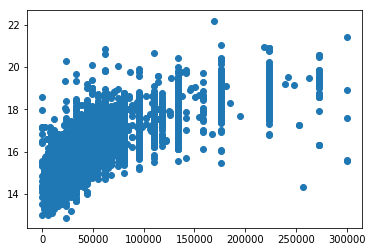

In [6]:
df.loc[:, "parking_price"] = df["parking_price"].clip(0.1, 300000)

train_num = train_Y.shape[0]
train_X = df[:train_num]

plt.scatter(train_X["parking_price"], train_Y)

In [7]:
parking_price = df['parking_price']
parking_area = df['parking_area']

df = df.drop(['parking_price'] , axis=1)
df = df.drop(['parking_area'] , axis=1)

df = df.fillna(df.mean())
df['parking_price'] = parking_price

In [8]:
park_not_null = df[df['parking_price'].notnull()]
park_is_null = df[df['parking_price'].isnull()].drop(['parking_price'] , axis=1)

park_X = park_not_null.drop(['parking_price'] , axis=1)
park_Y = np.log1p(park_not_null['parking_price'])

In [9]:
XGB = xgb.XGBRegressor()
XGB.fit(park_X, park_Y)

park_pred = XGB.predict(park_is_null)
df.loc[df['parking_price'].notnull(), 'parking_price'] = np.log1p(park_not_null['parking_price'])
df.loc[df['parking_price'].isnull(), 'parking_price'] = park_pred

df.head()

[23:36:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,building_material,city,txn_dt,total_floor,building_type,building_use,building_complete_dt,parking_way,txn_floor,land_area,...,XIV_500,XIV_index_500,XIV_1000,XIV_index_1000,XIV_5000,XIV_index_5000,XIV_10000,XIV_index_10000,XIV_MIN,parking_price
0,8,21,18674,4,3,2,6271,2,3.000000,18.144460,...,58,1,157,1,2483,1,6011,1,34.469803,5.480033
1,8,7,18800,5,1,2,7885,2,5.000000,11.387227,...,28,1,115,1,15872,1,32221,1,40.073573,10.412824
2,8,7,19289,4,1,2,6028,2,1.000000,21.426802,...,78,1,212,1,15760,1,32228,1,54.462081,10.463612
3,8,21,20385,24,0,2,18325,0,13.000000,11.387227,...,20,1,125,1,2568,1,7271,1,99.628966,11.303930
4,1,21,20657,2,4,2,6880,2,5.393906,61.306524,...,18,1,47,1,2587,1,7442,1,124.131236,8.313252


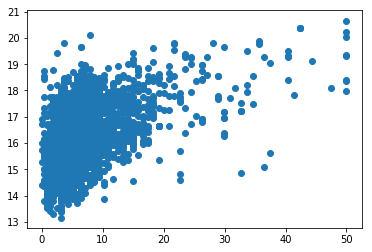

In [10]:
df['parking_area'] = parking_area
df.loc[:, "parking_area"] = df["parking_area"].clip(0.1, 50)

train_num = train_Y.shape[0]
train_X = df[:train_num]

plt.scatter(train_X["parking_area"], train_Y)

In [11]:
park_area_not_null = df[df['parking_area'].notnull()]
park_area_is_null = df[df['parking_area'].isnull()].drop(['parking_area'] , axis=1)

park_area_X = park_area_not_null.drop(['parking_area'] , axis=1)
park_area_Y = park_area_not_null['parking_area']

In [12]:
XGBR = xgb.XGBRegressor()
XGBR.fit(park_area_X, park_area_Y)

park_area_pred = XGBR.predict(park_area_is_null)

df.loc[df['parking_area'].isnull(), 'parking_area'] = park_area_pred

df.head()

[23:36:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,building_material,city,txn_dt,total_floor,building_type,building_use,building_complete_dt,parking_way,txn_floor,land_area,...,XIV_index_500,XIV_1000,XIV_index_1000,XIV_5000,XIV_index_5000,XIV_10000,XIV_index_10000,XIV_MIN,parking_price,parking_area
0,8,21,18674,4,3,2,6271,2,3.000000,18.144460,...,1,157,1,2483,1,6011,1,34.469803,5.480033,4.197453
1,8,7,18800,5,1,2,7885,2,5.000000,11.387227,...,1,115,1,15872,1,32221,1,40.073573,10.412824,2.721138
2,8,7,19289,4,1,2,6028,2,1.000000,21.426802,...,1,212,1,15760,1,32228,1,54.462081,10.463612,2.302792
3,8,21,20385,24,0,2,18325,0,13.000000,11.387227,...,1,125,1,2568,1,7271,1,99.628966,11.303930,6.734877
4,1,21,20657,2,4,2,6880,2,5.393906,61.306524,...,1,47,1,2587,1,7442,1,124.131236,8.313252,0.088575


In [13]:
temp_df = copy.deepcopy(df)

In [14]:
temp_df = temp_df.fillna(temp_df.mean())
temp_df["total_building_area"] = temp_df["building_area"] * temp_df["total_floor"]
temp_df["total_income"] = np.log1p(temp_df["village_income_median"] * temp_df["town_population"])
temp_df["area_percent"] = temp_df["land_area"] / temp_df["town_area"]
temp_df["per_parking_price"] = np.log1p(np.expm1(temp_df["parking_price"]) / temp_df["parking_area"])
temp_df["education_rate"] = temp_df["jobschool_rate"] + temp_df["highschool_rate"]

temp_df["village_income_median"] = np.log1p(temp_df["village_income_median"])
#df = pd.get_dummies(data = df, columns = ["city"])
#df = pd.get_dummies(data = df, columns = ["building_type"])

train_num = train_Y.shape[0]
train_X = temp_df[:train_num]
test_X = temp_df[train_num:]

/home/rex/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log1p
  """


In [15]:
data = pd.concat([temp_df[:train_num], train_Y], axis=1)
test_data = temp_df[train_num:]
cols = ["city","building_type"]

for c in cols:
    
    mean_df = data.groupby([c])['total_price'].mean().reset_index()
    mean_df.columns = [c, f'{c}_mean']
    
    data = pd.merge(data, mean_df, on= c, how='left')
    data = data.drop([c] , axis=1)
    
    test_data = pd.merge(test_data, mean_df, on= c, how='left')   
    test_data = test_data.drop([c] , axis=1)
    
data = data.drop(['total_price'] , axis=1)

In [16]:
temp_df = pd.concat([data,test_data])
temp_df.head()

,building_material,txn_dt,total_floor,building_use,building_complete_dt,parking_way,txn_floor,land_area,building_area,town,...,XIV_MIN,parking_price,parking_area,total_building_area,total_income,area_percent,per_parking_price,education_rate,city_mean,building_type_mean
0,8,18674,4,2,6271,2,3.000000,18.144460,3.418175,334,...,34.469803,5.480033,4.197453,13.672701,16.444032,12.812980,4.058798,0.429944,14.763179,15.617864
1,8,18800,5,2,7885,2,5.000000,11.387227,4.041309,180,...,40.073573,10.412824,2.721138,20.206544,19.530279,0.492159,9.411825,0.417768,15.734002,15.368964
2,8,19289,4,2,6028,2,1.000000,21.426802,5.584279,180,...,54.462081,10.463612,2.302792,22.337115,19.658113,0.926072,9.629527,0.417768,15.734002,15.368964
3,8,20385,24,2,18325,0,13.000000,11.387227,13.563031,343,...,99.628966,11.303930,6.734877,325.512737,18.700553,0.771895,9.396701,0.429944,14.763179,15.837634
4,1,20657,2,2,6880,2,5.393906,61.306524,4.688108,102,...,124.131236,8.313252,0.088575,9.376217,17.913927,0.862986,10.736937,0.429944,14.763179,15.429428


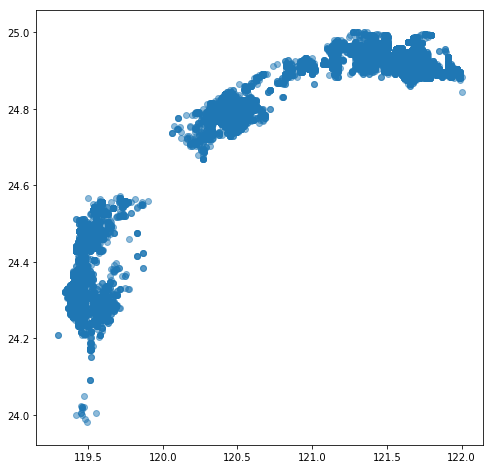

In [17]:
# make geo_df
geo = copy.deepcopy(temp_df)
geo["lat"] = geo["lat"] + 100
geo["lat"] = (geo["lat"]/geo["lat"].max())*25
geo["lon"] = (geo["lon"]/geo["lon"].max())*122

geo_df = geo[['lat', 'lon']]
#temp_df['lon'] = temp_df['lon']# / 1e6
#temp_df['lat'] = temp_df['lat'] #/ 1e6

x = np.array(geo_df['lon'])
y = np.array(geo_df['lat'])

fig = plt.figure(figsize=(8, 8))
plt.scatter(x, y, alpha=0.5)
plt.show()

In [18]:
temp_df["lat"] = geo["lat"]
temp_df["new_location"] = (geo["lat"]*geo["lon"])/100

In [19]:
train_X = temp_df[:train_num]

estimator = xgb.XGBRegressor()
estimator.fit(train_X, train_Y)
feats = pd.Series(data=estimator.feature_importances_, index=temp_df.columns)
feats = feats.sort_values(ascending=False)

[23:37:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [20]:
feats[feats!=0]

parking_price              0.166378
jobschool_rate             0.091195
XIII_10000                 0.083626
doc_rate                   0.065365
city_mean                  0.065168
VII_10000                  0.058216
master_rate                0.055659
building_area              0.055311
born_rate                  0.049575
village_income_median      0.029201
area_percent               0.020401
V_5000                     0.017183
X_5000                     0.016320
per_parking_price          0.013829
total_income               0.012523
land_area                  0.012102
XI_5000                    0.011338
V_10000                    0.011021
VII_1000                   0.010082
V_500                      0.009301
parking_area               0.008270
VII_500                    0.007963
IX_1000                    0.007790
I_10000                    0.007106
lon                        0.006897
building_complete_dt       0.005713
VIII_1000                  0.005597
XIII_5000                  0

In [21]:
temp_df = temp_df.fillna(temp_df.mean())
train_X = temp_df[:train_num]

est = RandomForestRegressor()
est.fit(train_X, train_Y)
feats_est = pd.Series(data=est.feature_importances_, index=temp_df.columns)
feats_est = feats_est.sort_values(ascending=False)

In [22]:
feats_est[feats_est!=0]

parking_price            4.196164e-01
building_area            3.559045e-01
jobschool_rate           2.612563e-02
land_area                2.580505e-02
XIII_10000               1.317227e-02
lon                      8.483931e-03
building_complete_dt     6.929713e-03
txn_dt                   5.372964e-03
total_building_area      5.281610e-03
XIII_5000                4.678567e-03
education_rate           4.640840e-03
VII_10000                4.616743e-03
parking_area             4.035909e-03
village_income_median    3.854829e-03
bachelor_rate            3.753431e-03
txn_floor                3.540894e-03
per_parking_price        3.345929e-03
area_percent             3.310181e-03
doc_rate                 3.277571e-03
VII_1000                 2.791707e-03
parking_way              2.696874e-03
total_floor              2.663665e-03
VI_10000                 2.508842e-03
XIV_5000                 2.434520e-03
master_rate              2.389436e-03
total_income             2.358561e-03
town_populat

In [23]:
high_feature = list(set(feats[feats!=0].index)&set(feats_est[feats_est!=0].index))

high_feature
    

['lon',
 'new_location',
 'per_parking_price',
 'X_5000',
 'N_50',
 'total_income',
 'divorce_rate',
 'II_5000',
 'V_1000',
 'VII_5000',
 'village_income_median',
 'parking_area',
 'XI_1000',
 'building_use',
 'VIII_500',
 'III_10000',
 'total_floor',
 'VII_500',
 'VII_10000',
 'XIV_10000',
 'V_500',
 'XII_500',
 'village',
 'town_area',
 'XIII_10000',
 'XIV_250',
 'IV_1000',
 'IV_5000',
 'jobschool_rate',
 'XIV_5000',
 'doc_rate',
 'V_MIN',
 'building_area',
 'V_10000',
 'land_area',
 'VII_1000',
 'XIII_MIN',
 'XI_10000',
 'parking_way',
 'III_1000',
 'txn_dt',
 'VIII_50',
 'building_type_mean',
 'VII_100',
 'VII_50',
 'born_rate',
 'X_MIN',
 'V_5000',
 'IX_1000',
 'V_250',
 'parking_price',
 'building_complete_dt',
 'city_mean',
 'IX_500',
 'total_building_area',
 'txn_floor',
 'X_100',
 'VIII_MIN',
 'XIII_5000',
 'XI_5000',
 'II_1000',
 'town_population_density',
 'VIII_250',
 'VI_5000',
 'area_percent',
 'VII_250',
 'lat',
 'VIII_1000',
 'town_population',
 'XII_10000',
 'I_10000',

In [24]:
#high_feature = list(feats[feats!=0].index)

train_X = temp_df[:train_num][high_feature]
test_X = temp_df[train_num:][high_feature]

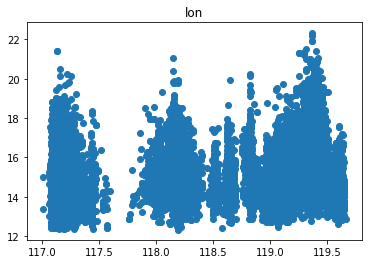

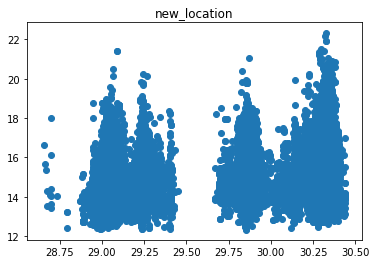

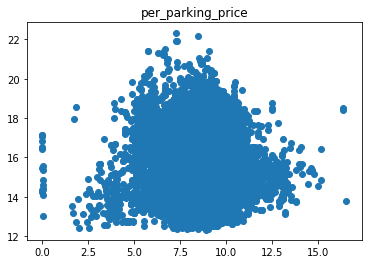

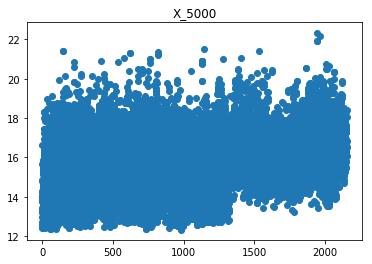

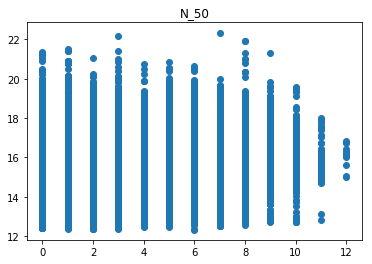

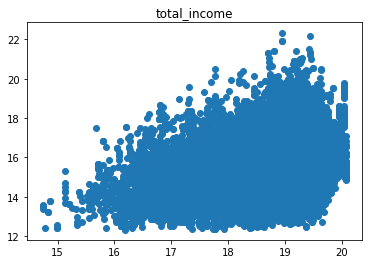

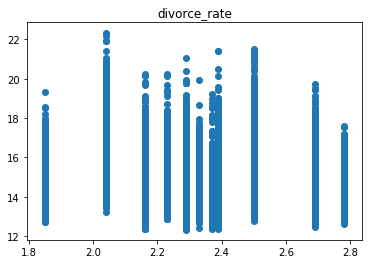

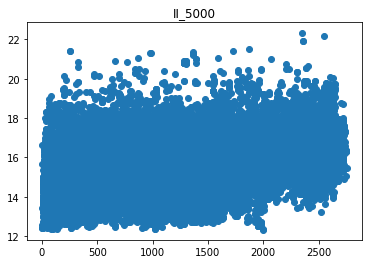

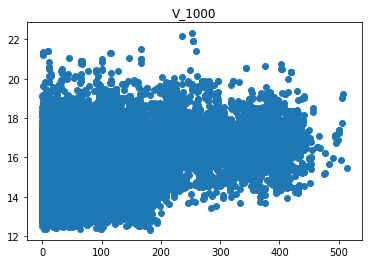

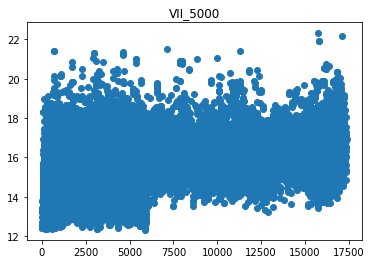

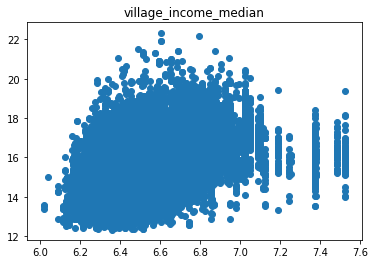

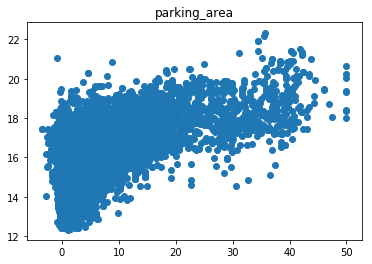

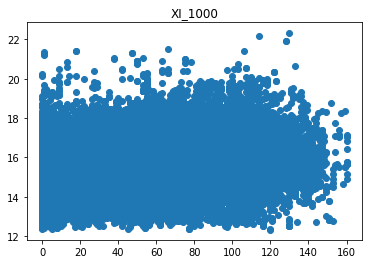

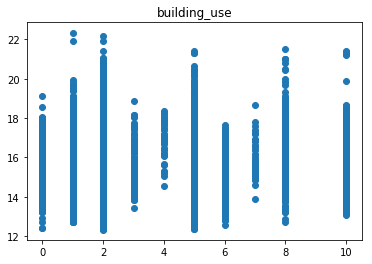

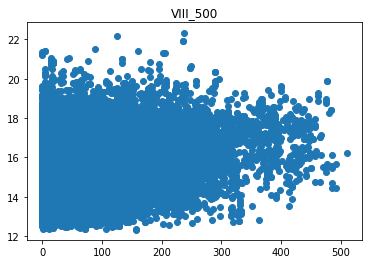

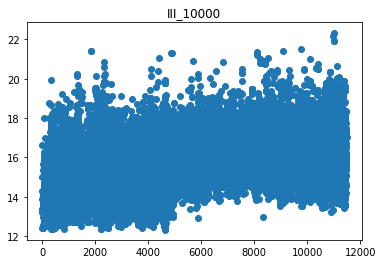

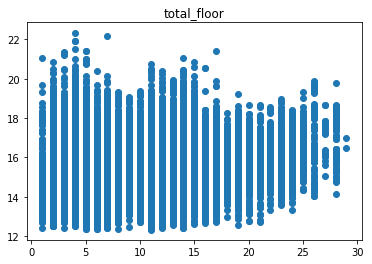

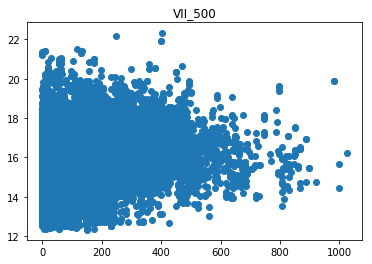

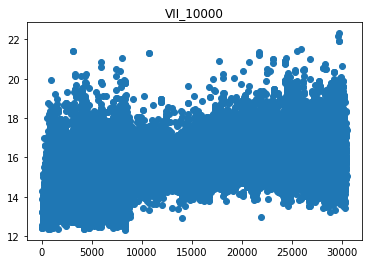

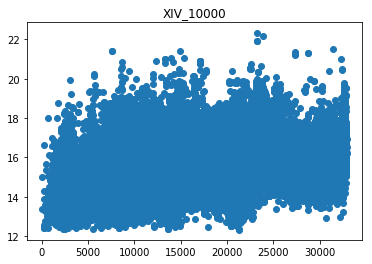

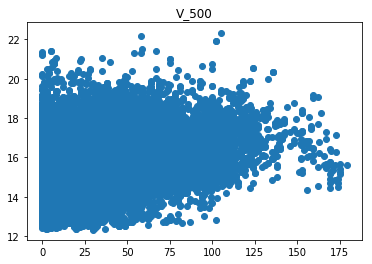

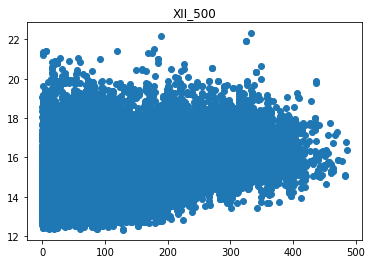

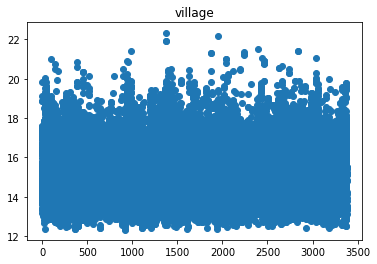

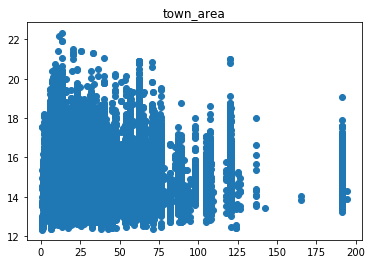

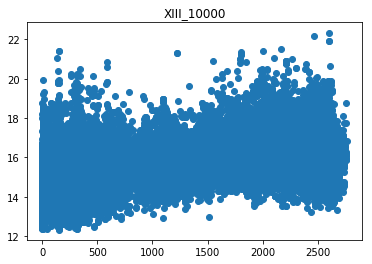

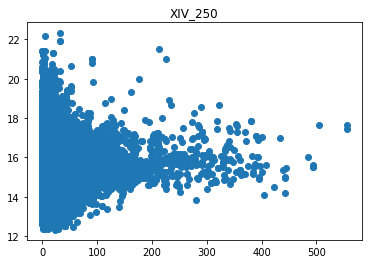

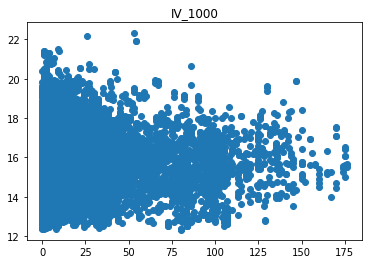

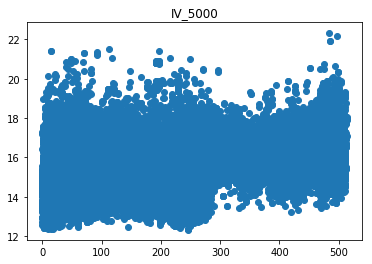

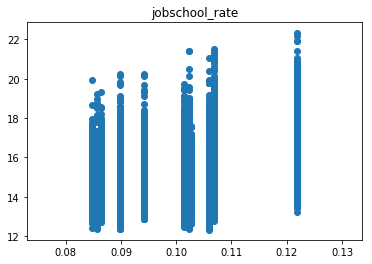

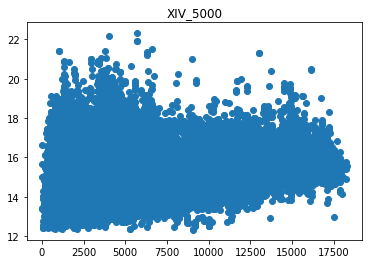

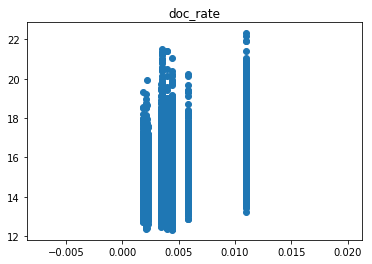

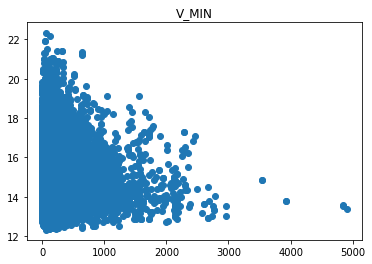

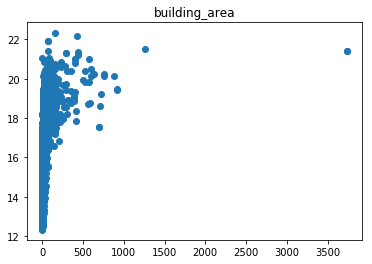

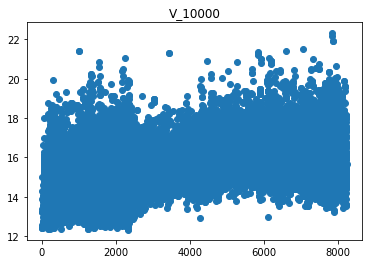

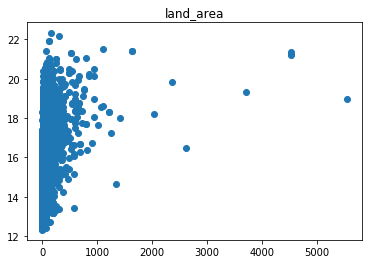

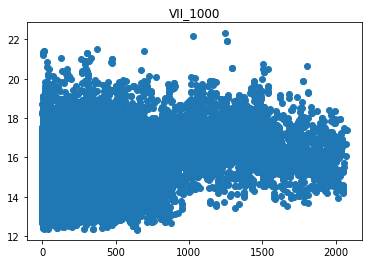

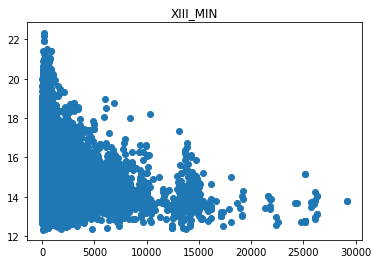

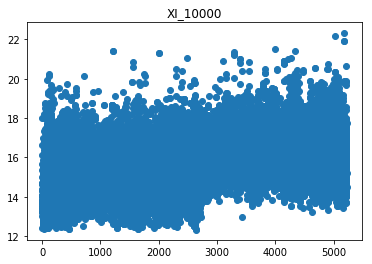

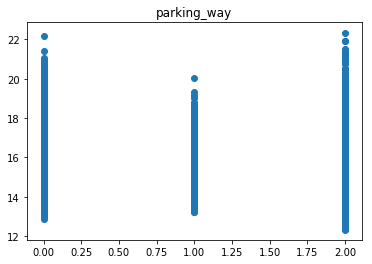

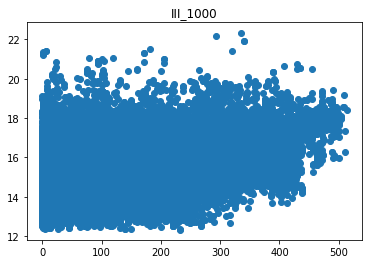

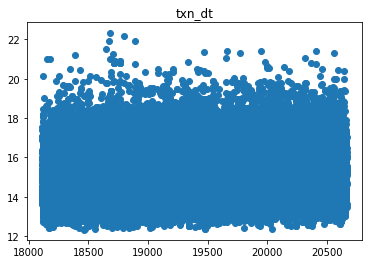

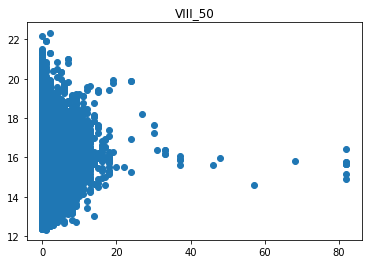

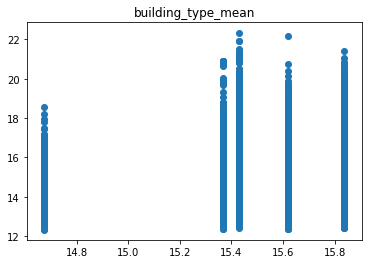

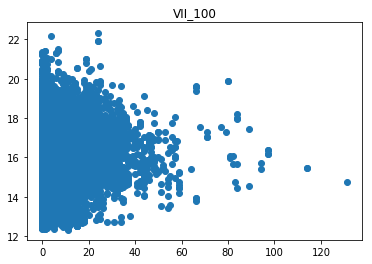

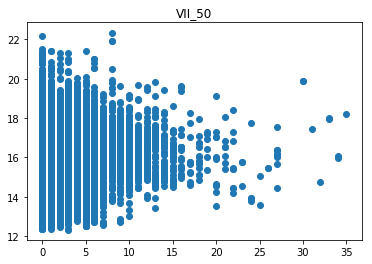

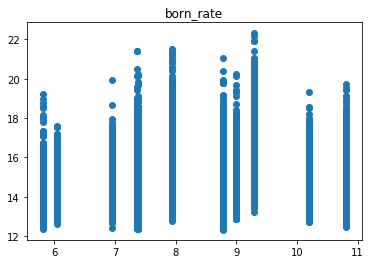

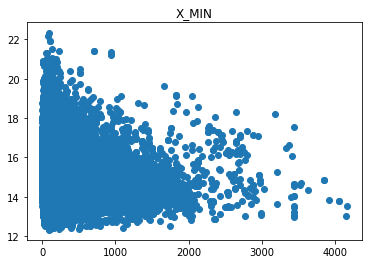

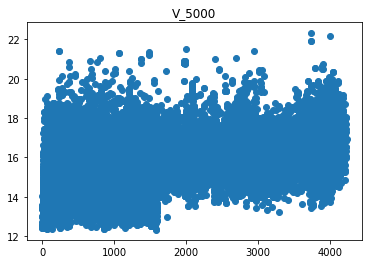

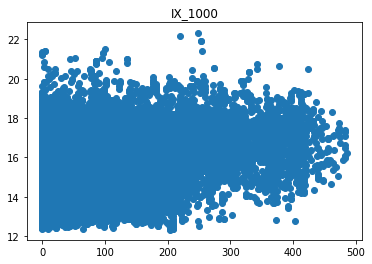

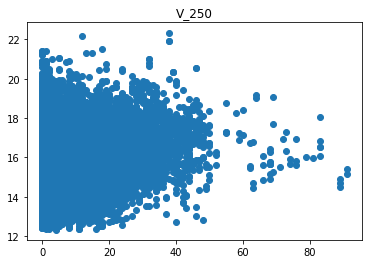

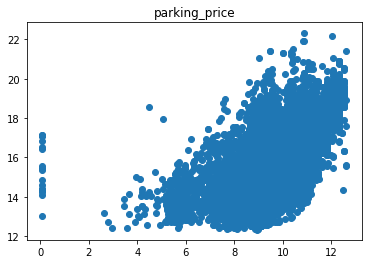

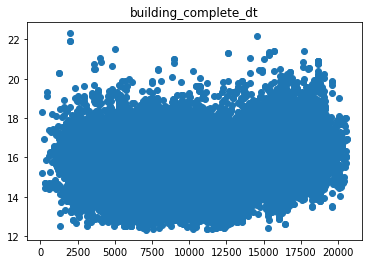

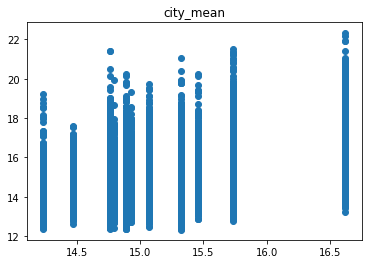

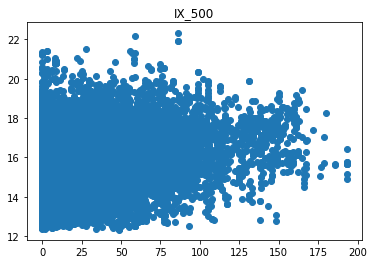

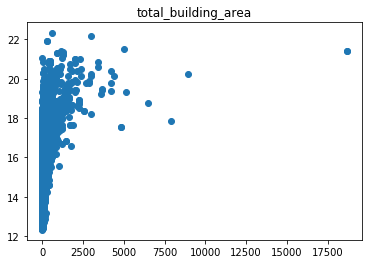

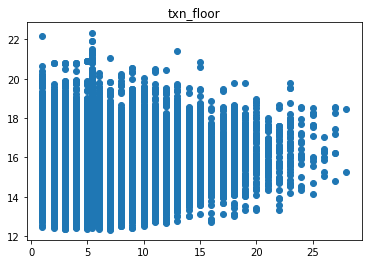

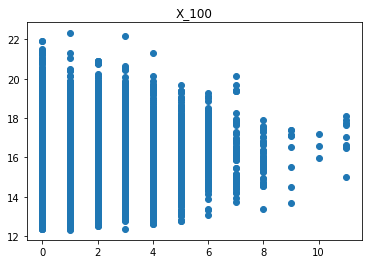

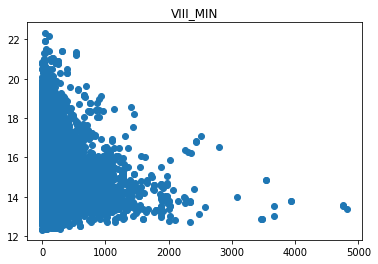

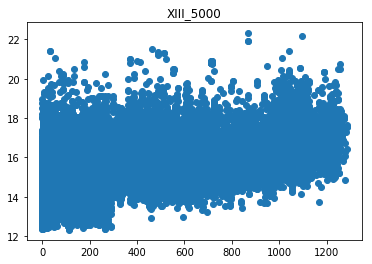

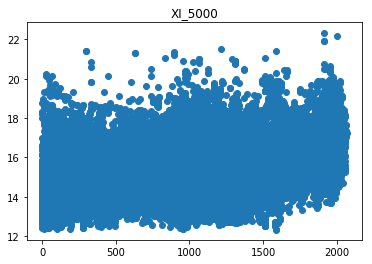

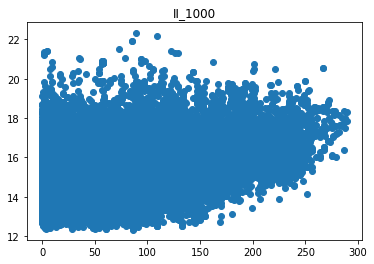

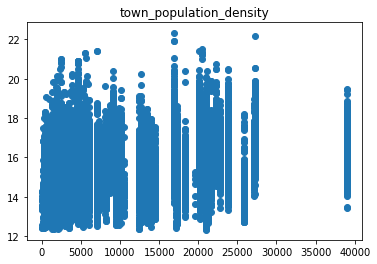

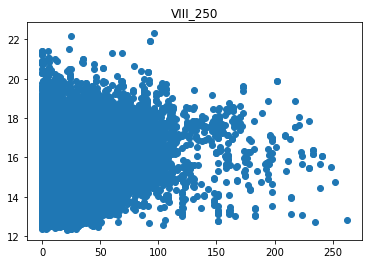

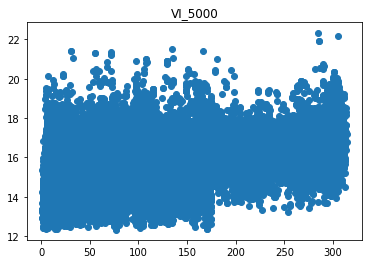

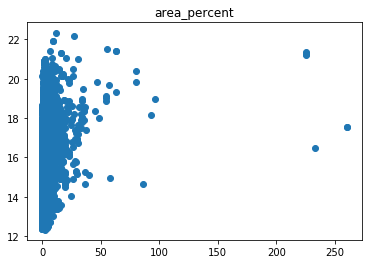

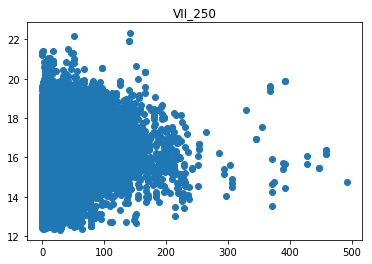

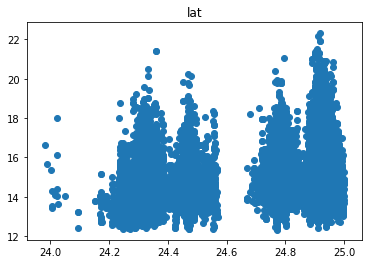

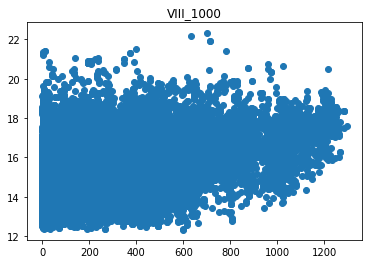

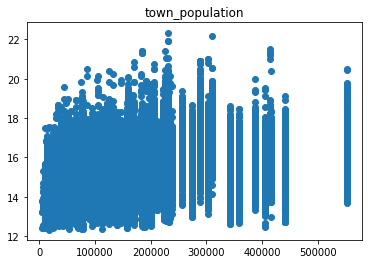

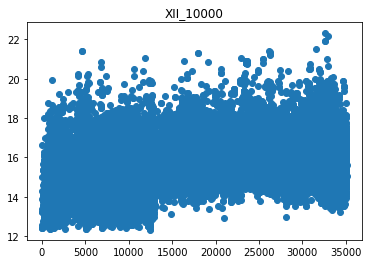

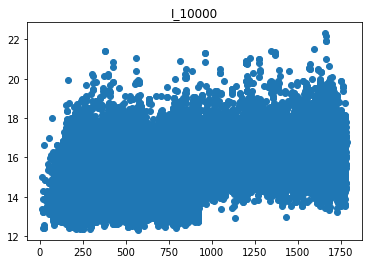

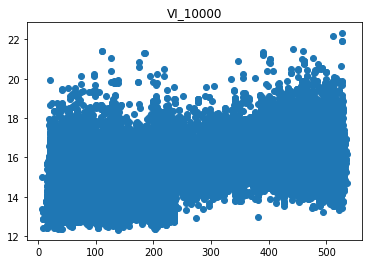

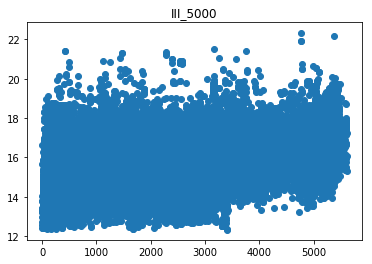

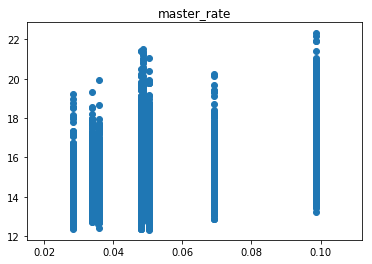

In [34]:
for col in high_feature:
    plt.scatter(train_X[col], train_Y)
    plt.title(col)
    plt.show()

In [92]:
# 切分訓練集/測試集
x_train, x_test, y_train, y_test = train_test_split(train_X, train_Y, test_size=0.25, random_state=4)

estimator_ = RandomForestRegressor(random_state=7)
estimator_.fit(x_train, y_train)

print(cross_val_score(estimator_, x_train, y_train, cv=5).mean())

y_pred = estimator_.predict(x_test)
print("Mean squared error: %.4f"
      % mean_squared_error(y_test, y_pred))

0.9404333575429122
Mean squared error: 0.0705


In [93]:
estimator_bestparam = RandomForestRegressor(random_state=7)
estimator_.fit(train_X, train_Y)

predict = estimator_.predict(test_X)

test_price = np.expm1(predict)

submit = pd.DataFrame(ids)
submit['total_price'] = test_price
submit.to_csv("2019-06-23.csv",index=False)